In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [ts for ts in filter_design_ts(X[0])]
ts = np.stack(ts)
print(ts.shape)

(847, 264, 124)


In [50]:
### import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

mseLoss = nn.MSELoss()

x = torch.from_numpy(ts).float().cuda()

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))
    
class EffSub(nn.Module):
    def __init__(self, n):
        super(EffSub, self).__init__()
        self.ec = nn.Parameter(torch.randn(n,264,264).float().cuda())
        self.c = nn.Parameter(mask(torch.ones(264,264).float().cuda()).unsqueeze(0))
        
    def get_ec(self, i=None):
        if i is not None:
            return self.c.squeeze()*self.ec[i]
        else:
            return self.c*self.ec
        
    def get_grp_ec(self):
        grpec = torch.mean(self.ec)
        grpec = self.c*grpec
        return grpec
        
    def forward(self, x):
        xi = x[:,:,:-2]
        ec = self.get_ec()
#         xhat1 = torch.einsum('nat,nab->nbt',xi,ec)
        xhat2 = torch.einsum('nat,nab->nbt',xi,ec)
        return xhat2
    
effsub = EffSub(x.shape[0])
optim = torch.optim.Adam([
    {'params': effsub.parameters(), 'lr': 1e-1, 'weight_decay': 1e-3},
])

nEpochs = 3000
pPeriod = 100
alpha = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    xhat = effsub(x)
    loss = mseLoss(xhat, x[:,:,2:])
    grploss = alpha*torch.mean((effsub.get_ec()-effsub.get_grp_ec())**2)
    (loss+grploss).backward()
    optim.step()
    sched.step(loss+grploss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} {float(grploss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

0 123.75288822387137 9.980850194520944 lr: [0.1]
100 7.029711203144079 0.06415937051625807 lr: [0.1]
200 6.563336709588175 0.08219601908832296 lr: [0.1]
300 6.242831582462576 0.10211882079841265 lr: [0.1]
400 6.038042266060936 0.11361011092150004 lr: [0.1]
500 5.907510935692144 0.1203371569212531 lr: [0.1]
600 5.822199450311625 0.12455144136375637 lr: [0.1]
700 5.766773140572983 0.12738984625194766 lr: [0.1]
800 5.728646808504762 0.12951202815948976 lr: [0.1]
900 5.691777894630696 0.13155987410745051 lr: [0.095]
1000 5.669408508881343 0.13342976879396815 lr: [0.08145062499999998]
1100 5.650868252907578 0.13479221468680921 lr: [0.07350918906249998]
1200 5.640409766658396 0.13579723559265752 lr: [0.06634204312890622]
1300 5.630800266068096 0.13653081511072218 lr: [0.0630249409724609]
1400 5.6245528997116985 0.13708097294129956 lr: [0.05688000922764597]
1500 5.619411829243397 0.13752925951626122 lr: [0.05403600876626367]
1600 5.615928116112837 0.13789177129555394 lr: [0.04876749791155295]

/tmp/ipykernel_64089/42098243.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


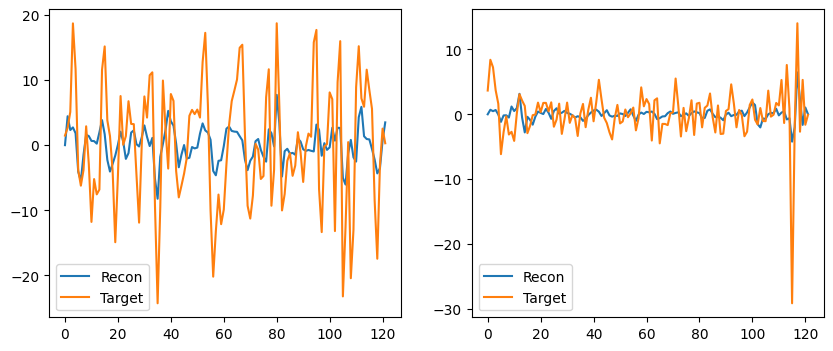

In [51]:
# View reconstruction

import matplotlib.pyplot as plt

xhatnp = xhat.detach().cpu().numpy()
xonp = x[:,:,2:].detach().cpu().numpy()

sub0 = 40
sub1 = 110
roi = 50

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(xhatnp[sub0,roi],label='Recon')
ax[0].plot(xonp[sub0,roi],label='Target')
ax[0].legend()
ax[1].plot(xhatnp[sub1,roi],label='Recon')
ax[1].plot(xonp[sub1,roi],label='Target')
ax[1].legend()
fig.show()

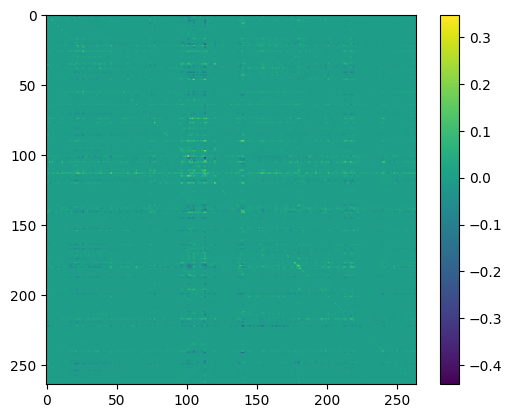

In [52]:
def subec(effsub, i):
    with torch.no_grad():
        ec = effsub.get_ec(i).squeeze()
        return ec.detach().cpu().numpy()
    
plt.imshow(subec(effsub, 11)-subec(effsub, 10))
plt.colorbar()
plt.show()

In [61]:
# xec = torch.cat([effsub.a, effsub.b], dim=2).detach().clone()
xec = effsub.get_ec()
xec = xec.clone().detach()
xec = xec.reshape(xec.shape[0],-1)
# mu = torch.mean(xec, dim=0, keepdims=True)
# std = torch.std(xec, dim=0, keepdims=True)
# xec = (xec-mu)/std

xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 69696])
torch.Size([600, 69696])
torch.Size([247, 69696])
(847,)


In [28]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [57]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,1).float().cuda()
        
    def forward(self, x):
        y = self.l0(x).squeeze()
        return y

mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-1, weight_decay=5e-2)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
#     l1loss = 1e-1*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.6574742936229 lr: [0.1]
1000 43.74959542223648 lr: [0.1]
2000 34.77066676924854 lr: [0.1]
3000 30.099756831710867 lr: [0.1]
4000 28.26129950665198 lr: [0.1]
5000 27.85767376851428 lr: [0.08145062499999998]
6000 27.83991253543137 lr: [0.0010956636797406032]
7000 27.83986430343355 lr: [1.0292605961181944e-05]
8000 27.83986430343355 lr: [1.9937959796869698e-06]
9000 27.83986430343355 lr: [1.9937959796869698e-06]
9999 27.83986430343355 lr: [1.9937959796869698e-06]
Complete
tensor(37.0253, device='cuda:0', grad_fn=<PowBackward0>)


In [59]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.3, edp=0, wInit=1e-4, dim=10, temp=1)
optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.081035164810956 lr: [0.001]
100 12.132108197523062 lr: [0.001]
200 9.84478192445809 lr: [0.000857375]
300 9.12712009831483 lr: [0.0007350918906249997]
400 8.637920487543347 lr: [0.0005688000922764595]
500 8.396379653408943 lr: [0.00046329123015975297]
600 8.20315383179457 lr: [0.00032353354497370894]
700 8.212767769963996 lr: [0.0002503440897424548]
800 8.045210879201385 lr: [0.00017482461472379692]
900 7.9057923437051585 lr: [0.00011598222130000548]
999 7.995925103940273 lr: [7.69449752767131e-05]
Complete
tensor(36.0209, device='cuda:0', grad_fn=<PowBackward0>)


In [68]:
mseLoss(torch.mean(ytr),yt)**0.5

/usr/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([247])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(38.2108, device='cuda:0')